# Spatial selection with tripolar ACCESS-OM2 grid

The ACCESS-OM2 model collection utilises a tripolar grid north of 65N to avoid a point of convergence over the ocean at the north pole.

This means any plotting or analysis in this region needs to use 2D curvilinear latitude and longitude coordinates.

This notebook will cover how to use the curvilinear coordinates to select data within latitude and longitude limits, and how to plot data in the tripole region correctly. There is also a [full tutorial on plotting with projections](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#gallery-tutorials-making-maps-with-cartopy-ipynb).

Below the tripole area it is sufficient to use 1D latitude and longitude coordinates, which are much more convenient to use as they can use the [`xarray`](http://xarray.pydata.org/en/stable/index.html) [`sel`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html) method with `slice` notation.

This notebook will also demonstrate how to do this.

The data output from the CICE model component do not have a convenient to use 1D latitude and longitude coordinates. As the ice and ocean models share a grid the coordinates from each model can be used interchangeably with the other. A method to add 1D latitude and longitude coordinates to an ice [`xarray.DataArray`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) is also demonstrated.



In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

## Load data

Open a database session

In [2]:
session = cc.database.create_session(db='/g/data/ik11/databases/cosima_master.db')

The specific experiment does not matter a great deal. This is the main IAF control run with JRA55 v1.4 forcing

In [3]:
expt='01deg_jra55v140_iaf'

Load the 1D latitude/longitude variables from the ocean data to use them with ice data. The dimensions are renamed to match the required dimension in the ice data

In [4]:
yt_ocean = cc.querying.getvar(expt, 'yt_ocean', session, 'ocean-2d-geolat_t.nc', n=1).rename({'yt_ocean': 'latitude'})
xt_ocean = cc.querying.getvar(expt, 'xt_ocean', session, 'ocean-2d-geolat_t.nc', n=1).rename({'xt_ocean': 'longitude'})

Both the ocean and the ice output variables have masked curvilinear coordinates, which means there are missing values for the coordinates over land. These variables are not suitable for plotting with [cartopy](https://scitools.org.uk/cartopy/docs/latest/). A full curvilinear grid is available from the CICE model input grid:

In [5]:
ice_grid = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_eee21b65/cice_01deg/grid.nc')

Extract the full curvilinear coordinates, from the ice grid. Note that these are in radians and so neeed to converted to degrees, and again the dimensions are renamed to match the dataset to which they will be added:

In [6]:
geolon_t = xr.ufuncs.degrees(ice_grid.tlon.rename({'nx': 'longitude', 'ny': 'latitude'}))
geolat_t = xr.ufuncs.degrees(ice_grid.tlat.rename({'nx': 'longitude', 'ny': 'latitude'}))

Load an ice variable to use as an example dataset. In this case only the first 12 months for purposes of illustration.

In [7]:
aice_m = cc.querying.getvar(expt,'aice_m', session, n=12)

Printing the variable shows it has non-informative dimension names and no CF coordinate variables. As a result when the first time slice is plotted there is no useful units automatically added to the plot. 

In [8]:
aice_m

<xarray.DataArray 'aice_m' (time: 12, nj: 2700, ni: 3600)>
dask.array<concatenate, shape=(12, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
    ULON     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    TLON     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
  * time     (time) object 1958-02-01 00:00:00 ... 1959-01-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

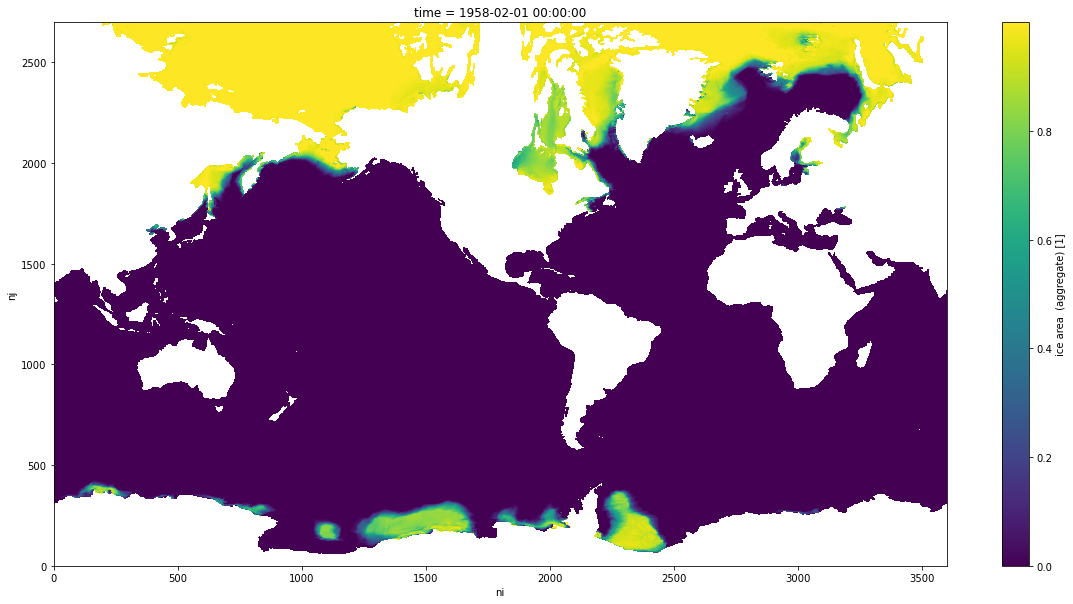

In [9]:
aice_m.isel(time=0).plot(aspect=2,size=10);

## Add spatial coordinates

To improve usability CF compatible spatial coordinates from the ocean data loaded above can be added to the ice data.

The unintuitive dimensions are renamed, and importantly match the dimension names chosen for the coordinates. The coordinates loaded above are added to the `DataArray`, and saved in a new variable, `aice_m_coords`.

In [10]:
aice_m_coords = aice_m.rename({'nj':'latitude', 
                               'ni':'longitude'}).assign_coords({'latitude': yt_ocean, 
                                                                 'longitude': xt_ocean, 
                                                                 'geolat_t': geolat_t, 
                                                                 'geolon_t': geolon_t})
aice_m_coords

<xarray.DataArray 'aice_m' (time: 12, latitude: 2700, longitude: 3600)>
dask.array<concatenate, shape=(12, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
    ULON       (latitude, longitude) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULAT       (latitude, longitude) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    TLON       (latitude, longitude) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    TLAT       (latitude, longitude) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
  * time       (time) object 1958-02-01 00:00:00 ... 1959-01-01 00:00:00
  * latitude   (latitude) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * longitude  (longitude) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolat_t   (latitude, longitude) float64 -81.11 -81.11 ... 65.06 65.02
    geolon_t   (latitude, longitude) float64 -279.9 -279.8 -279.7 ... 80.0 80.0
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

Now when the first time slice is plotted there are informative axes as there are now CF compliant dimensions `latitude` and `longitude`.

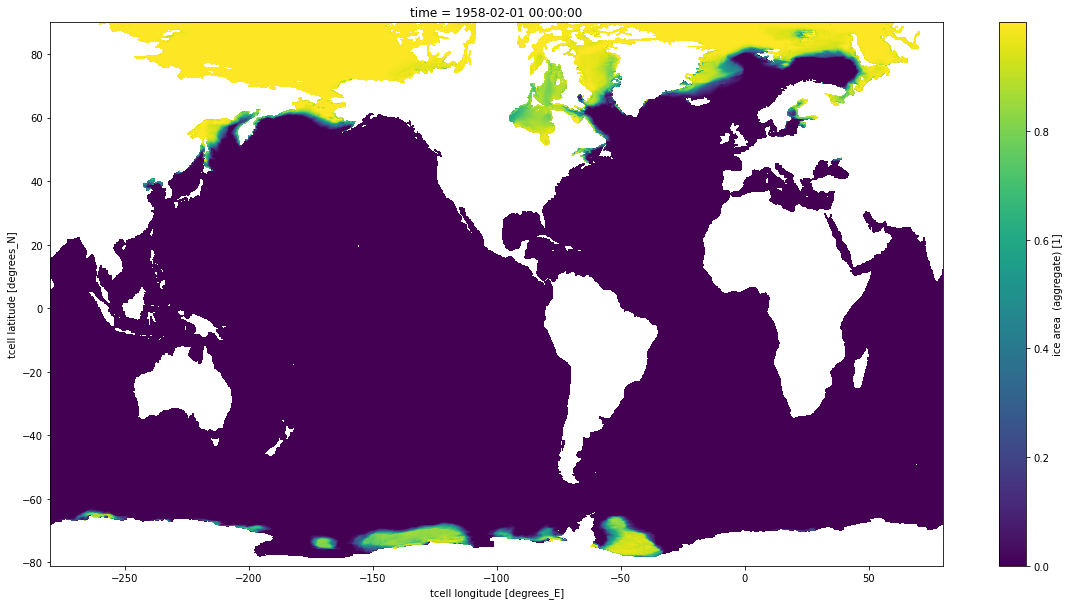

In [11]:
aice_m_coords.isel(time=0).plot(aspect=2,size=10);

## Selection using sel and slice

Also selection using slices of latitude and longitude are easy using these new dimensions. e.g. selecting the Weddell Sea in Antarctica

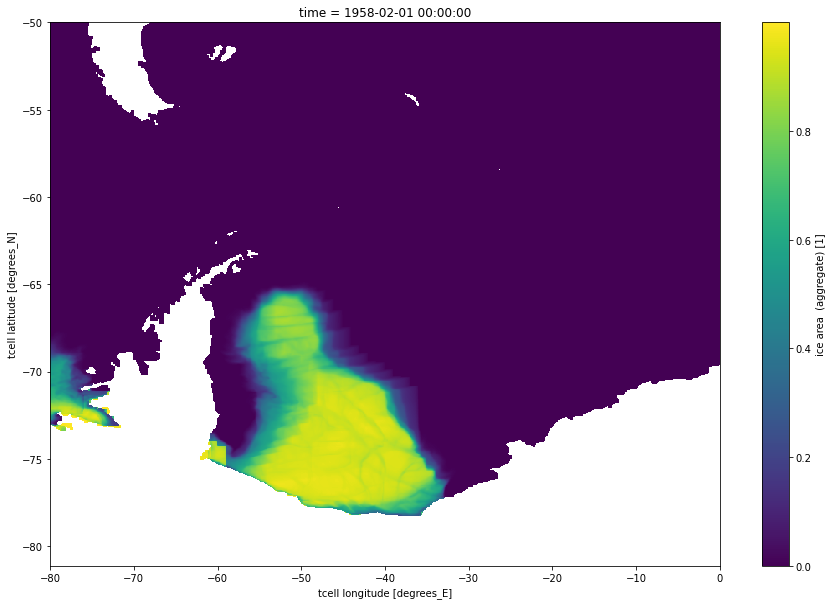

In [12]:
aice_m_coords.isel(time=0).sel(longitude=slice(-80,0),latitude=slice(None,-50)).plot(size=10)

The same data can also be plotted and projected using `cartopy` which works fine using the 1D `latitude` and `longitude` coordinates as these are correct for all values south of 65N, so all of the Southern Hemisphere.

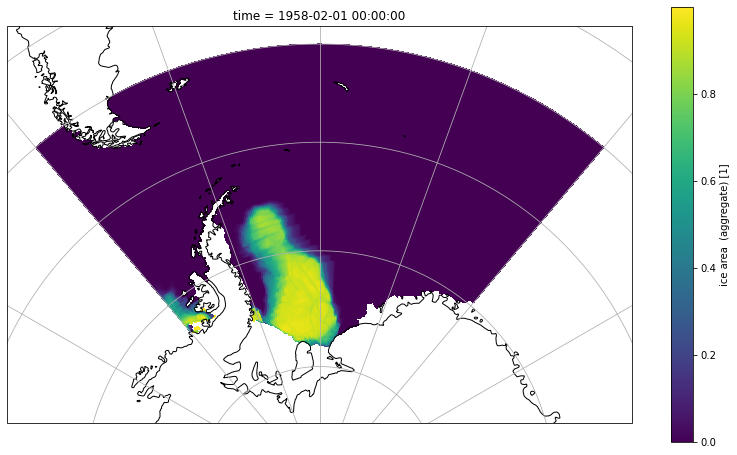

In [13]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Orthographic(-40,-90))
ax.coastlines()
ax.gridlines()
aice_m_coords.isel(time=0).sel(longitude=slice(-80,0),
                               latitude=slice(None,-50)).plot(ax=ax, transform=ccrs.PlateCarree());

Simple `sel` with `slice` can also be used to select areas in the northern hemisphere, but they appear distorted  as this area is in the tripole, so the 1D latitude and longitude variables are not correct

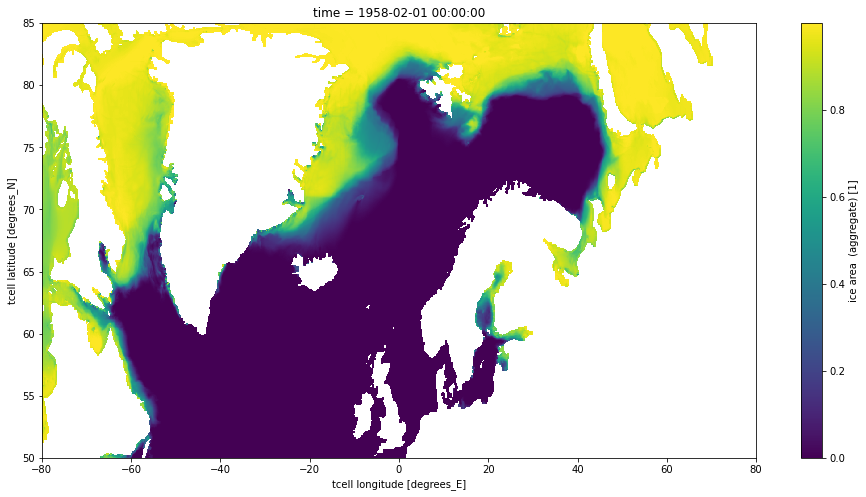

In [14]:
aice_m_coords.isel(time=0).sel(longitude=slice(-80,80), 
                               latitude=slice(50,85)).plot(size=8, aspect=2);

If the same selection is plotted in an Orthographic projection with `cartopy` it is obvious that land/sea boundaries are not correct, and artefacts from the tripole are visible

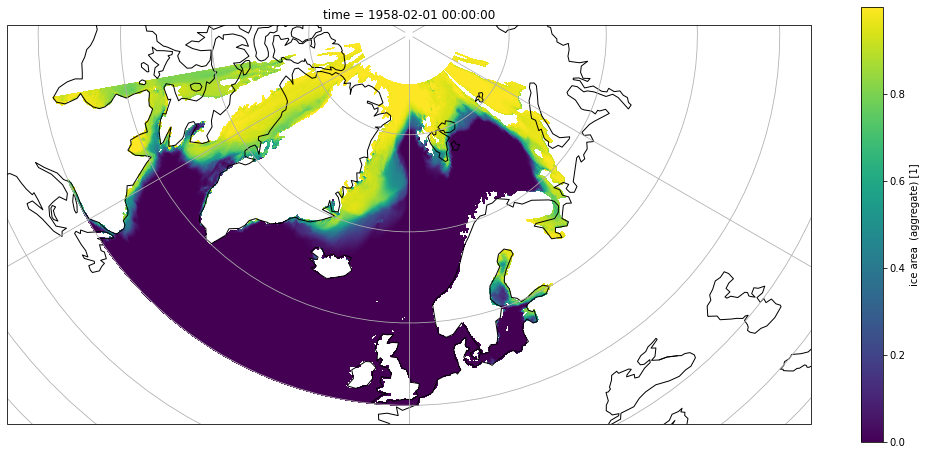

In [15]:
fig = plt.figure(figsize=(18,8))
ax = plt.axes(projection=ccrs.Orthographic(0,90))
ax.coastlines()
ax.gridlines()
aice_m_coords.isel(time=0).sel(longitude=slice(-80,80), 
                               latitude=slice(50,85)).plot(ax=ax, transform=ccrs.PlateCarree());

Using the true curvilinear coordinates to plot, the artefacts are removed, and the land/sea registration is correct, but the simple `sel` using the 1D coordinates means there are not constant lines of latitude or longitude in the selected data.

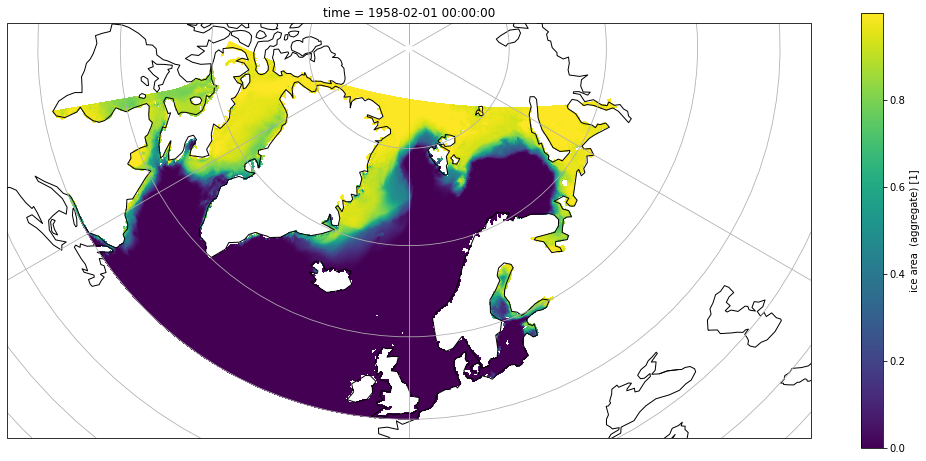

In [16]:
fig = plt.figure(figsize=(18,8))
ax = plt.axes(projection=ccrs.Orthographic(0,90))
ax.coastlines()
ax.gridlines()
aice_m_coords.isel(time=0).sel(longitude=slice(-80,80), 
                               latitude=slice(50,85)).plot(ax=ax, 
                                                           transform=ccrs.PlateCarree(), 
                                                           x='geolon_t',y='geolat_t');

## Selection using where

To do proper spatial selection with 2D coordinates in the tripole area it is necessary to use the `xarray` [`where`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html) method, which will mask out the data where the stipulated condition is not met. With `drop=True` coordinate labels with only `False` values are removed.

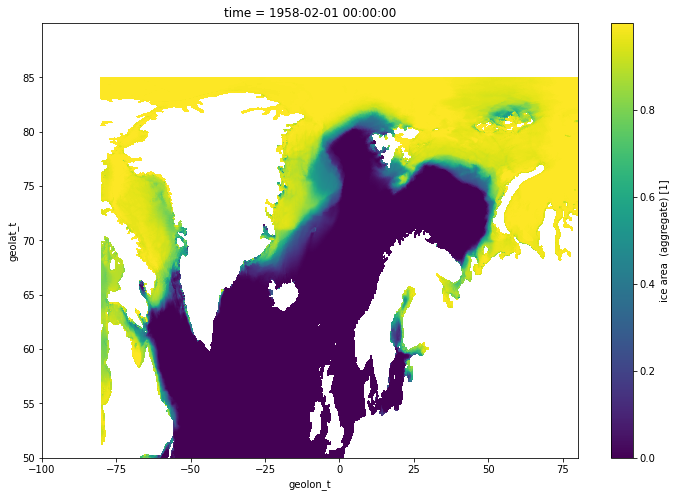

In [17]:
aice_m_coords.isel(time=0).where((geolon_t >= -80) & 
                                 (geolon_t <= 80) & 
                                 (geolat_t >= 50) & 
                                 (geolat_t <= 85),drop=True).plot(size=8, 
                                                                  x='geolon_t',
                                                                  y='geolat_t');

Now when plotted in Orthographic projection with `cartopy` the selection is clearly along lines of constant latitude, and the left hand side selection is a constant longitude.

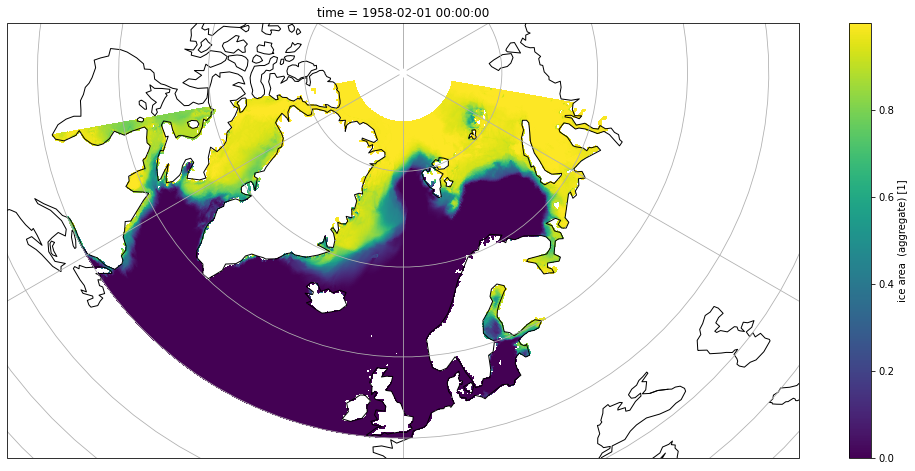

In [18]:
fig = plt.figure(figsize=(18,8))
ax = plt.axes(projection=ccrs.Orthographic(0,90))
ax.coastlines()
ax.gridlines()
aice_m_coords.isel(time=0).where((aice_m_coords.geolon_t >= -80) & 
                                 (aice_m_coords.geolon_t <= 80) & 
                                 (aice_m_coords.geolat_t >= 50) & 
                                 (aice_m_coords.geolat_t <= 85), drop=True).plot(ax=ax, 
                                                                     transform=ccrs.PlateCarree(), 
                                                                     x='geolon_t',y='geolat_t');